In [1]:
import sys
import os

# Get the absolute path of parent folder
current_dir = os.path.abspath("")
parent_dir = os.path.join(current_dir, os.pardir)

# Add to sys.path
sys.path.append(parent_dir)

In [2]:
import ml_combat as ml

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
autogl_df = pd.read_csv('../submissions/AutoGluon_wo_negative.csv')
comptree_df = pd.read_csv('../submissions/TreeCompositeHenrik.csv')

In [5]:
autogl_df['prediction'] = (autogl_df['prediction'] + comptree_df['prediction']) / 2

KeyError: 'y'

In [2]:
LOCATIONS = ["A", "B", "C"]

In [14]:
train = ml.data.get_training()

test = ml.data.get_testing()
train_oha = train.groupby(level = [0,2], axis = 1).mean()[['y', 'observed']] # o = observed, h = hourly, a = averaged (hourly)
train_eha = train.groupby(level = [0,2], axis = 1).mean()[['y', 'estimated']] # o = observed, h = hourly, a = averaged (hourly)

MultiIndex([('A', '2019-06-02 22:00:00'),
            ('A', '2019-06-02 23:00:00'),
            ('A', '2019-06-03 00:00:00'),
            ('A', '2019-06-03 01:00:00'),
            ('A', '2019-06-03 02:00:00'),
            ('A', '2019-06-03 03:00:00'),
            ('A', '2019-06-03 04:00:00'),
            ('A', '2019-06-03 05:00:00'),
            ('A', '2019-06-03 06:00:00'),
            ('A', '2019-06-03 07:00:00'),
            ...
            ('C', '2023-04-30 14:00:00'),
            ('C', '2023-04-30 15:00:00'),
            ('C', '2023-04-30 16:00:00'),
            ('C', '2023-04-30 17:00:00'),
            ('C', '2023-04-30 18:00:00'),
            ('C', '2023-04-30 19:00:00'),
            ('C', '2023-04-30 20:00:00'),
            ('C', '2023-04-30 21:00:00'),
            ('C', '2023-04-30 22:00:00'),
            ('C', '2023-04-30 23:00:00')],
           names=['location', 'datetime'], length=101363)

In [55]:
# Create total radiance feature
train_oha["feat_eng", "total_rad_1h:J"] = train_oha["observed", "diffuse_rad_1h:J"] + train_oha["observed", "direct_rad_1h:J"]

['location', 'datetime']
['location', 'datetime']


feature_type                              y                estimated  \
feature_name                 pv_measurement absolute_humidity_2m:gm3   
location datetime                                                      
A        2019-06-02 22:00:00           0.00                      NaN   
         2019-06-02 23:00:00           0.00                      NaN   
         2019-06-03 00:00:00           0.00                      NaN   
         2019-06-03 01:00:00           0.00                      NaN   
         2019-06-03 02:00:00          19.36                      NaN   

feature_type                                                           \
feature_name                 air_density_2m:kgm3 ceiling_height_agl:m   
location datetime                                                       
A        2019-06-02 22:00:00                 NaN                  NaN   
         2019-06-02 23:00:00                 NaN                  NaN   
         2019-06-03 00:00:00                 NaN                  NaN   
         2019-06-03 01:00:00                 NaN                  NaN   
         2019-06-03 02:00:00                 NaN                  NaN   

feature_type                                                        \
feature_name                 clear_sky_energy_1h:J clear_sky_rad:W   
location datetime                                                    
A        2019-06-02 22:00:00                   NaN             NaN   
         2019-06-02 23:00:00                   NaN             NaN   
         2019-06-03 00:00:00                   NaN             NaN   
         2019-06-03 01:00:00                   NaN             NaN   
         2019-06-03 02:00:00                   NaN             NaN   

feature_type                                                                  \
feature_name                 cloud_base_agl:m dew_or_rime:idx dew_point_2m:K   
location datetime                                                              
A        2019-06-02 22:00:00              NaN             NaN            NaN   
         2019-06-02 23:00:00              NaN             NaN            NaN   
         2019-06-03 00:00:00              NaN             NaN            NaN   
         2019-06-03 01:00:00              NaN             NaN            NaN   
         2019-06-03 02:00:00              NaN             NaN            NaN   

feature_type                                ...      observed                  \
feature_name                 diffuse_rad:W  ... sun_azimuth:d sun_elevation:d   
location datetime                           ...                                 
A        2019-06-02 22:00:00           NaN  ...    348.036758        -3.77425   
         2019-06-02 23:00:00           NaN  ...     91.980751        -4.35725   
         2019-06-03 00:00:00           NaN  ...     14.934750        -3.30950   
         2019-06-03 01:00:00           NaN  ...     28.630250        -0.82250   
         2019-06-03 02:00:00           NaN  ...     41.997500         3.05125   

feature_type                                                             \
feature_name                 super_cooled_liquid_water:kgm2 t_1000hPa:K   
location datetime                                                         
A        2019-06-02 22:00:00                            0.0  286.224998   
         2019-06-02 23:00:00                            0.0  286.899994   
         2019-06-03 00:00:00                            0.0  286.949997   
         2019-06-03 01:00:00                            0.0  286.750000   
         2019-06-03 02:00:00                            0.0  286.449997   

feature_type                                                    \
feature_name                 total_cloud_cover:p  visibility:m   
location datetime                                                
A        2019-06-02 22:00:00             100.000  40386.475586   
         2019-06-02 23:00:00             100.000  33770.649414   
         2019-06-03 00:00:00             100.000  13595.

In [56]:
def train_linear_model(location):
    if(location not in LOCATIONS): raise Exception("INVALID LOCATION")
    # Sample DataFrame
    df = train_oha.loc[location][[['y', 'pv_measurement'], ['feat_eng', 'total_rad_1h:J']]]

    # Drop rows where "total_rad_1h:J" AND "pv_measurement" is NaN
    df = df.dropna(axis=0, how="all", subset=[("feat_eng", "total_rad_1h:J")])
    df = df.dropna(axis=0, how="all", subset=[("y", "pv_measurement")])

    df.columns = df.columns.droplevel()

    print(df.head())

    # Splitting the data into training and test sets (70% training, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(df['total_rad_1h:J'], df['pv_measurement'], test_size=0.001, random_state=0)

    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

    return model

In [57]:
"""
PREDICTION AND PLOTTING FOR LINEAR MODELS

    # Make predictions on the test set
    y_pred = model.predict(X_test.values.reshape(-1, 1))


    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # If you want to predict for a new value
    new_value = [[6]]
    predicted_value = model.predict(new_value)
    print(f"Predicted value for input {new_value[0][0]} is: {predicted_value[0]}")


    # Scatter plot of actual vs. predicted values
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # diagonal line for perfect prediction
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted')
    plt.show()


    r2 = model.score(X_test.values.reshape(-1, 1), y_test)
    print(f"R-squared: {r2}")

"""

'\nPREDICTION AND PLOTTING FOR LINEAR MODELS\n\n    # Make predictions on the test set\n    y_pred = model.predict(X_test.values.reshape(-1, 1))\n\n\n    # Calculate the mean squared error of the predictions\n    mse = mean_squared_error(y_test, y_pred)\n    print(f"Mean Squared Error: {mse}")\n\n    # If you want to predict for a new value\n    new_value = [[6]]\n    predicted_value = model.predict(new_value)\n    print(f"Predicted value for input {new_value[0][0]} is: {predicted_value[0]}")\n\n\n    # Scatter plot of actual vs. predicted values\n    plt.scatter(y_test, y_pred, color=\'blue\')\n    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], \'k--\', lw=2)  # diagonal line for perfect prediction\n    plt.xlabel(\'Actual Values\')\n    plt.ylabel(\'Predicted Values\')\n    plt.title(\'Actual vs. Predicted\')\n    plt.show()\n\n\n    r2 = model.score(X_test.values.reshape(-1, 1), y_test)\n    print(f"R-squared: {r2}")\n\n'

In [58]:
models = {}

for location in LOCATIONS:
    models[location] = train_linear_model(location)

feature_name         pv_measurement  total_rad_1h:J
datetime                                           
2019-06-02 22:00:00            0.00        0.000000
2019-06-02 23:00:00            0.00        0.000000
2019-06-03 00:00:00            0.00        0.000000
2019-06-03 01:00:00            0.00      526.775024
2019-06-03 02:00:00           19.36    22351.924713
feature_name         pv_measurement  total_rad_1h:J
datetime                                           
2019-01-01 00:00:00             0.0             0.0
2019-01-01 01:00:00             0.0             0.0
2019-01-01 02:00:00             0.0             0.0
2019-01-01 03:00:00             0.0             0.0
2019-01-01 04:00:00             0.0             0.0
feature_name         pv_measurement  total_rad_1h:J
datetime                                           
2019-09-04 08:00:00           137.2    1.280451e+06
2019-09-04 09:00:00             0.0    1.599908e+06
2019-09-04 10:00:00             0.0    1.790924e+06
2019-09-04 1

# Linear regression model
Training-data: Using observed total_rad vs. pv_measurement (actual)
Using this on test-data to make output

In [59]:
test_eha = test.groupby(level = [0,2], axis = 1).mean() # o = observed, h = hourly, a = averaged (hourly)
test_eha["feat_eng", "total_rad_1h:J"] = test_eha["estimated", "diffuse_rad_1h:J"] + test_eha["estimated", "direct_rad_1h:J"]


#df = train_oha.loc[location][[['y', 'pv_measurement'], ['feat_eng', 'total_rad_1h:J']]]


X_tests = {}

y_tests = {}

for location in LOCATIONS:
    X_tests[location] = test_eha.loc[location][[['feat_eng', 'total_rad_1h:J']]]
    print(X_tests)
    y_tests[location] = models[location].predict(X_tests[location])
    


print(y_tests)

#model.predict()

{'A': feature_type              feat_eng
feature_name        total_rad_1h:J
datetime                          
2023-05-01 00:00:00       0.000000
2023-05-01 01:00:00       0.000000
2023-05-01 02:00:00       0.000000
2023-05-01 03:00:00   20610.576172
2023-05-01 04:00:00  151780.906250
...                            ...
2023-07-03 19:00:00  219737.796875
2023-07-03 20:00:00  116887.000000
2023-07-03 21:00:00   34579.050781
2023-07-03 22:00:00    2350.725098
2023-07-03 23:00:00       0.000000

[720 rows x 1 columns]}
{'A': feature_type              feat_eng
feature_name        total_rad_1h:J
datetime                          
2023-05-01 00:00:00       0.000000
2023-05-01 01:00:00       0.000000
2023-05-01 02:00:00       0.000000
2023-05-01 03:00:00   20610.576172
2023-05-01 04:00:00  151780.906250
...                            ...
2023-07-03 19:00:00  219737.796875
2023-07-03 20:00:00  116887.000000
2023-07-03 21:00:00   34579.050781
2023-07-03 22:00:00    2350.725098
2023-07-03 23:00:0

In [60]:
dfa = pd.DataFrame(y_tests['A'])
dfb = pd.DataFrame(y_tests['B'])
dfc = pd.DataFrame(y_tests['C'])

C:\Users\Henrik\AppData\Local\Temp\ipykernel_6928\3881467606.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  X_tests["A"].reset_index().merge(dfa, left_index=True, right_index=True)[[('feat_eng', 'total_rad_1h:J'), 0]].plot.scatter(x=('feat_eng', 'total_rad_1h:J'), y=0)
c:\Users\Henrik\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<Axes: xlabel='(feat_eng, total_rad_1h:J)', ylabel='0'>

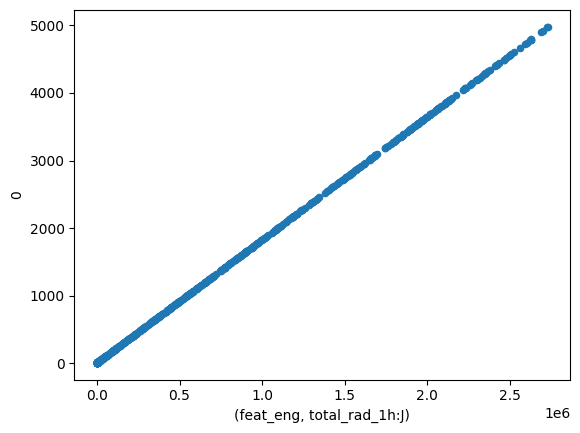

In [61]:
X_tests["A"].reset_index().merge(dfa, left_index=True, right_index=True)[[('feat_eng', 'total_rad_1h:J'), 0]].plot.scatter(x=('feat_eng', 'total_rad_1h:J'), y=0)

In [62]:
df = pd.concat([dfa, dfb, dfc]).reset_index(drop=True).reset_index()

In [63]:
df.rename(columns={'index':'id',0:'prediction'}).to_csv('lin.csv',index=False)

# TRY ON ESTIMATED INSTEAD OF OBSERVED


R^2 ends up being = 0.7881701135634888

In [64]:
"""
train_eha["feat_eng", "total_rad_1h:J"] = train_eha["estimated", "diffuse_rad_1h:J"] + train_eha["estimated", "direct_rad_1h:J"]


# Sample DataFrame
df = train_eha.loc['A'][[['y', 'pv_measurement'], ['feat_eng', 'total_rad_1h:J']]]

# Drop rows where "total_rad_1h:J" AND "pv_measurement" is NaN
df = df.dropna(axis=0, how="all", subset=[("feat_eng", "total_rad_1h:J")])
df = df.dropna(axis=0, how="all", subset=[("y", "pv_measurement")])

df.columns = df.columns.droplevel()

print(df.head())

# Splitting the data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(df['total_rad_1h:J'], df['pv_measurement'], test_size=0.3, random_state=0)


# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

# Make predictions on the test set
y_pred = model.predict(X_test.values.reshape(-1, 1))


# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# If you want to predict for a new value
new_value = [[6]]
predicted_value = model.predict(new_value)
print(f"Predicted value for input {new_value[0][0]} is: {predicted_value[0]}")


# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # diagonal line for perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()


r2 = model.score(X_test.values.reshape(-1, 1), y_test)
print(f"R-squared: {r2}")
"""

'\ntrain_eha["feat_eng", "total_rad_1h:J"] = train_eha["estimated", "diffuse_rad_1h:J"] + train_eha["estimated", "direct_rad_1h:J"]\n\n\n# Sample DataFrame\ndf = train_eha.loc[\'A\'][[[\'y\', \'pv_measurement\'], [\'feat_eng\', \'total_rad_1h:J\']]]\n\n# Drop rows where "total_rad_1h:J" AND "pv_measurement" is NaN\ndf = df.dropna(axis=0, how="all", subset=[("feat_eng", "total_rad_1h:J")])\ndf = df.dropna(axis=0, how="all", subset=[("y", "pv_measurement")])\n\ndf.columns = df.columns.droplevel()\n\nprint(df.head())\n\n# Splitting the data into training and test sets (70% training, 30% test)\nX_train, X_test, y_train, y_test = train_test_split(df[\'total_rad_1h:J\'], df[\'pv_measurement\'], test_size=0.3, random_state=0)\n\n\n# Create a linear regression model\nmodel = LinearRegression()\n\n# Train the model\nmodel.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))\n\n# Make predictions on the test set\ny_pred = model.predict(X_test.values.reshape(-1, 1))\n\n\n# Calculate 